## **Problem Set 1: Attitude, Rigid Body, Lagrange**

#### **Problem №1: Lie Integration**

Consider the kinematics of a rotating body parametrized with quaternions, as described by the following ODE:

$$
\dot{\mathbf{q}} = \frac{1}{2}\mathbf{q} \otimes \hat{\boldsymbol{\omega}}
$$

where $\mathbf{q} \in \mathbb{S}^3$ is the unit quaternion and $\hat{\boldsymbol{\omega}} = [0, \boldsymbol{\omega}]$ is the "angular velocity quaternion" with $\boldsymbol{\omega} \in \mathbb{R}^3$ being the angular velocity.

Do the following:

* **[10 points]** When selecting a random angular velocity $\boldsymbol{\omega}$, use either the forward or backward Euler method to simulate the motion of the system. Afterwards, check the norm of the quaternion, plot trajectories, and animate the motion, then discuss the results.
* **[10 points]** Instead of Euler integration, apply the following technique: $\mathbf{q}_{k+1} = \mathbf{q}_k \otimes \text{exp}(\frac{1}{2}\hat{\boldsymbol{\omega}}_kdt)$, where $\text{exp}(\mathbf{q})$ is the **quaternion exponential**. Check the norm of the quaternion, plot the trajectories, animate the motion, and compare the results with Euler integration.

---


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable, List
from visualize import visualize_rotation
from visualize_pend import visualize_double_pendulum
from scipy.integrate import odeint

np.set_printoptions(precision=4)

In [2]:
%matplotlib inline

In [46]:
def q_mul(q1: np.ndarray, q2: np.ndarray) -> np.ndarray:
    return np.array(
        [
            q1[0] * q2[0] - q1[1:].dot(q2[1:]),
            *(q1[0] * q2[1:] + q2[0] * q1[1:] + np.cross(q1[1:], q2[1:]))
        ]
    )


def conj(q: np.ndarray) -> np.ndarray:
    return np.array([q[0], *(-q[1:])])


def complete(v: np.ndarray) -> np.ndarray:
    return np.array([0, *v])


def arb_q(angle: float, axis: np.ndarray) -> np.ndarray:
    return np.array([np.cos(angle), *(np.sin(angle) * axis)])


def qt_rot(q: np.ndarray) -> np.ndarray:
    ident = np.eye(3)
    q_c = conj(q)
    return np.c_[
        q_mul(q_mul(q, complete(ident[:, 0])), q_c)[1:],
        q_mul(q_mul(q, complete(ident[:, 1])), q_c)[1:],
        q_mul(q_mul(q, complete(ident[:, 2])), q_c)[1:]
    ]


def exponent(q: np.ndarray) -> np.ndarray:
    v = q[1:]
    r = q[0]
    v_norm = np.linalg.norm(v)
    return np.exp(r) * np.array([np.cos(v_norm), *(v * np.sin(v_norm) / v_norm)])


def as_matrix(q: np.ndarray) -> np.ndarray:
    return np.array(
        [
            [q[0], -q[1], -q[2], -q[3]],
            [q[1], q[0], -q[3], q[2]],
            [q[2], q[3], q[0], -q[1]],
            [q[3], -q[2], q[1], q[0]]
        ]
    )

In [47]:
class Solver:
    def __init__(self, x_0: np.ndarray, t_span: np.ndarray,
                 f: Callable[[np.ndarray, float], np.ndarray]):
        self.x_0 = np.array(x_0)
        self.t_span = t_span
        self.f = f
        self.dt = t_span[1] - t_span[0]

    def solve(self) -> np.ndarray:
        raise NotImplementedError()


class ForwardEuler(Solver):
    def solve(self) -> np.ndarray:
        res = [self.x_0]
        for t_val in self.t_span[:-1]:
            res.append(
                res[-1] + self.f(res[-1], t_val) * self.dt
            )
        return np.array(res)


class BackwardEuler(Solver):
    def __init__(self, x_0: np.ndarray, t_span: np.ndarray,
                 f: Callable[[np.ndarray, float], np.ndarray],
                 jac: Callable[[np.ndarray, float], np.ndarray],
                 epsilon: float = 10 ** -6):
        super().__init__(x_0, t_span, f)
        self.jac = jac
        self.__identity = np.eye(self.x_0.shape[0])
        self.epsilon = epsilon

    def __eval(self, x_prev: np.ndarray, x_next: np.ndarray, t_next: float) -> np.ndarray:
        return x_next - x_prev - self.dt * self.f(x_next, t_next)

    def __jac(self, x_next: np.ndarray, t_next: float) -> np.ndarray:
        return self.__identity - self.dt * self.jac(x_next, t_next)

    def __find_root(self, x_prev: np.ndarray, t_next: float) -> np.ndarray:
        x_c = x_prev
        f_val = self.__eval(x_prev, x_c, t_next)
        jac_val = self.__jac(x_c, t_next)

        while np.linalg.norm(f_val) > self.epsilon:
            x_c = x_c - np.linalg.inv(jac_val).dot(f_val)
            f_val = self.__eval(x_prev, x_c, t_next)
            jac_val = self.__jac(x_c, t_next)

        return x_c

    def solve(self) -> np.ndarray:
        res = [self.x_0]
        for t_val in self.t_span[1:]:
            res.append(
                self.__find_root(res[-1], t_val)
            )
        return np.array(res)

In [48]:
OMEGA = np.random.random(3)
Q_O = np.array((1, 0, 0, 0))
N = 1000
T_SPAN = np.linspace(0, 10, N)
print(OMEGA)

[0.855  0.1809 0.5989]


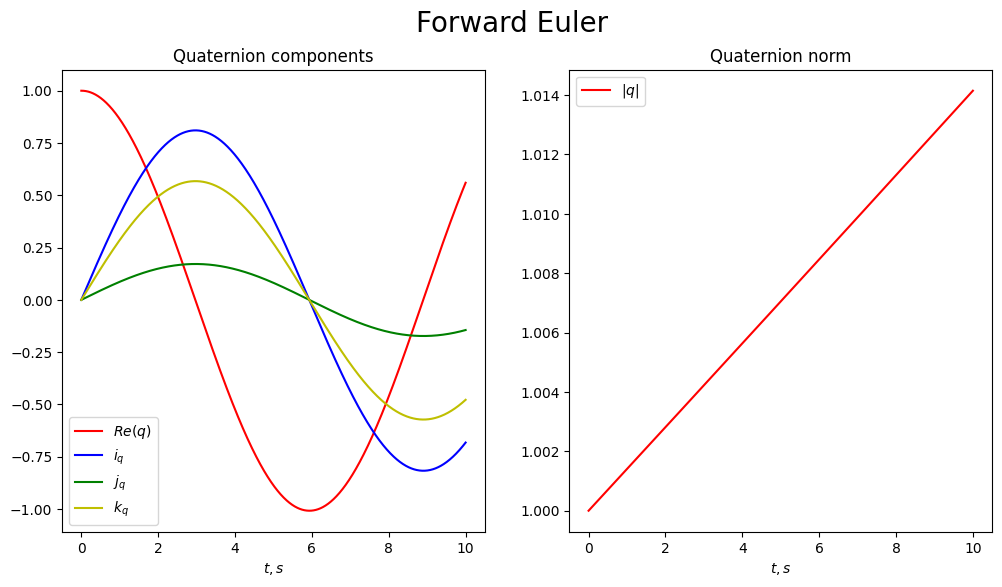

<Figure size 640x480 with 0 Axes>

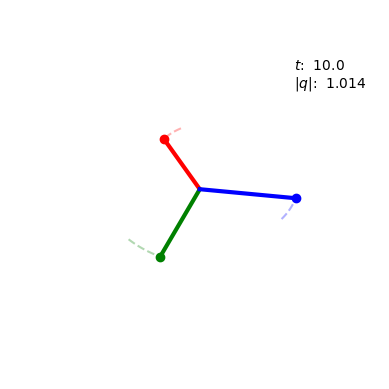

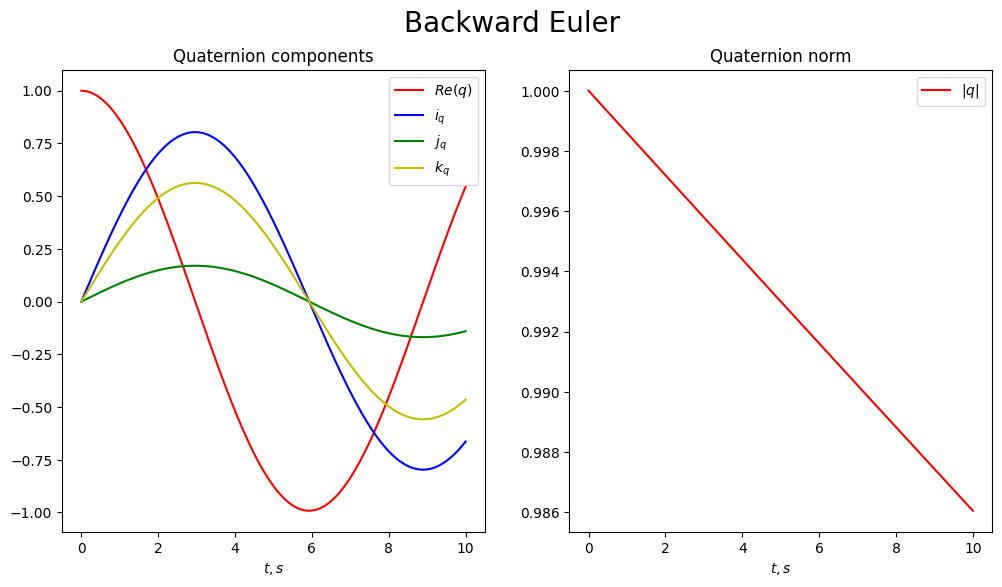

<Figure size 640x480 with 0 Axes>

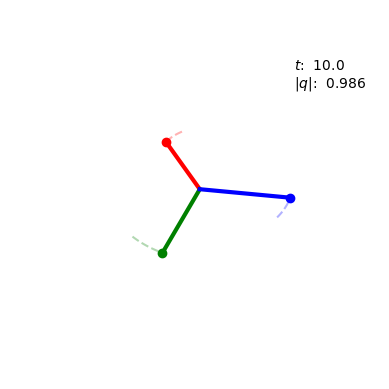

In [49]:
def plot_results_1(q_s: np.ndarray, t_span: np.ndarray, integrator: str):
    fig: plt.Figure
    axes: List[plt.Axes]
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(integrator, fontsize=20)

    axes[0].set_title('Quaternion components')
    axes[0].plot(t_span, q_s[:, 0], color='r', label='$Re(q)$')
    axes[0].plot(t_span, q_s[:, 1], color='b', label='$i_q$')
    axes[0].plot(t_span, q_s[:, 2], color='g', label='$j_q$')
    axes[0].plot(t_span, q_s[:, 3], color='y', label='$k_q$')
    axes[0].set_xlabel('$t, s$')
    axes[0].legend(loc='best')

    axes[1].set_title('Quaternion norm')
    axes[1].plot(t_span, np.linalg.norm(q_s, axis=1), color='r', label='$|q|$')
    axes[1].set_xlabel('$t, s$')
    axes[1].legend(loc='best')

    plt.show()

    # Animate rotation
    plt.clf()
    rot_ms = []
    for q in q_s:
        rot_ms.append(qt_rot(q))
    stats = [['$t$', t_span], ['$|q|$', np.linalg.norm(q_s, axis=1)]]
    animation = visualize_rotation(np.array(rot_ms), stats=stats, verbose=False, show=False)

    integrator = integrator.replace(' ', '_')
    with open(f'task_1_{integrator}.html', 'w') as f:
        f.write(animation.to_jshtml())


def sim_euler(omega: np.ndarray, q_0: np.ndarray, t_span: np.ndarray):
    omega_q = complete(omega)
    euler = ForwardEuler(q_0, t_span, lambda x, _: q_mul(x, omega_q) / 2)
    sol = euler.solve()
    plot_results_1(sol, t_span, 'Forward Euler')


def sim_back_euler(omega: np.ndarray, q_0: np.ndarray, t_span: np.ndarray):
    omega_q = complete(omega)
    i_s = -np.eye(4)
    i_s[0][0] = 1
    l_omega_c = as_matrix(conj(omega_q))

    back_euler = BackwardEuler(q_0, t_span, lambda x, _: q_mul(x, omega_q) / 2,
                               lambda x, _: i_s.dot(l_omega_c).dot(i_s))
    sol = back_euler.solve()
    plot_results_1(sol, t_span, 'Backward Euler')


sim_euler(OMEGA, Q_O, T_SPAN)
sim_back_euler(OMEGA, Q_O, T_SPAN)

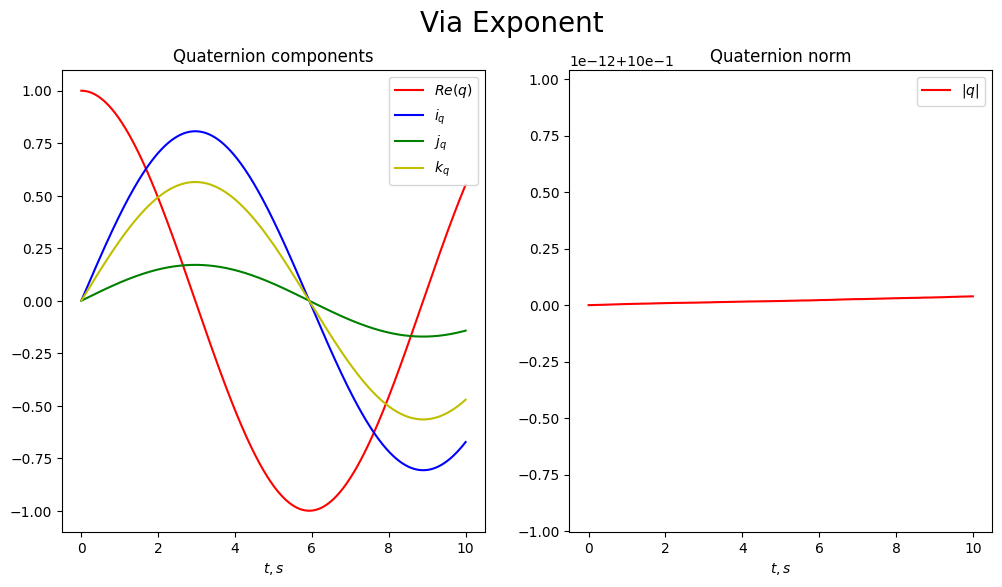

<Figure size 640x480 with 0 Axes>

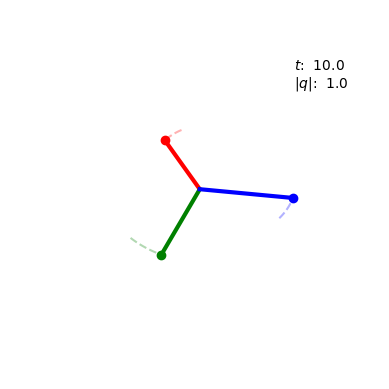

In [50]:
# It keeps |q| = 1, because |e^x| = 1 and |a * b| = |a||b|
def sim_via_exponent(omega: np.ndarray, q_0: np.ndarray, t_span: np.ndarray):
    omega_q = complete(omega)
    sol = [q_0]
    dt = t_span[1] - t_span[0]
    for _ in range(len(t_span) - 1):
        sol.append(q_mul(sol[-1], exponent(omega_q * dt / 2)))
    sol = np.array(sol)
    plot_results_1(sol, t_span, 'Via Exponent')


sim_via_exponent(OMEGA, Q_O, T_SPAN)

#### **Problem №2: Quadrotor Attitude**

Consider the model of quadrotor:
<p align="center">
<img src="https://drive.google.com/uc?id=1S2ZENdiebtmfD4RGuv3mUAVXWoZpAEDL" alt="drawing" width="50%" style="margin:auto"/>
</p>

with following parameters

In [51]:
m = 0.1  # [kg] - mass of the motors
M = 0.5  # [kg] mass of the drone body
h = 0.08  # [m] high of the body
R = 0.05  # [m] radius of the body
l = 0.3  # [m] length of arm
k_t = 0.05  # thrust coefficient
k_m = 0.001  # torque coefficient

Follow the steps below:

* **[10 points]** Derive the dynamics of the drone using the propeller speeds $\Omega_i > 0$ as input (recall the lecture on a single rigid body).

* **[10 points]** Simulate the attitude using normalized quaternions and a 4th-order Runge-Kutta algorithm given random propeller speeds, simulate and animate the motion (recall [practice 3](https://docs.google.com/document/d/134ubHnAKN8aM4MRp0NxQsbsdTSLJSWoZv3mZqFrSRQ/edit)).

* **[20 points]** Deduce the inputs that support rotation around the $x$, $y$, and $z$ axes of the body frame (subsequently), simulate and animate the motion.
---

Common dynamics:
$
    \begin{bmatrix} \dot{\mathbf{q}} \\ \dot{\mathbf{\omega}}_b \end{bmatrix} =
    \begin{bmatrix}
        \frac{1}{2} \mathbf{q} \otimes \hat{\mathbf{\omega}}_b \\
        I_b^{-1}(\mathbf{\tau}_b - \mathbf{\omega}_b \times I_b \mathbf{\omega}_b)
    \end{bmatrix}
$

Drone is fixed at center of mass, thus no torques are created from gravity forces. Therefore:

$
    \mathbf{\tau}_b =
    \begin{bmatrix}
        0 & -k_2 & 0 & k_4 \\
        -k_1 & 0 & k_3 & 0 \\
        -b_1 & -b_2 & -b_3 & -b_4
    \end{bmatrix}
    \begin{bmatrix}
        \Omega_1 \\ \Omega_2 \\ \Omega_3 \\ \Omega_4
    \end{bmatrix}
$

Tensor of inertia along principal axes:

$
    I_b =
    \begin{bmatrix}
        \frac{1}{12}Mh^2 + \frac{1}{4}MR^2 + 2ml^2 & 0 & 0 \\
        0 & \frac{1}{12}Mh^2 + \frac{1}{4}MR^2 + 2ml^2 & 0 \\
        0 & 0 & \frac{1}{2}MR^2 + 4ml^2
    \end{bmatrix}
$


In [52]:
K1 = K2 = K3 = K4 = k_t
B1 = B2 = B3 = B4 = k_m
N = 1000
T_SPAN = np.linspace(0, 10, N)

TAU_MATRIX = np.array(
    [
        [0, -K2, 0, K4],
        [-K1, 0, K3, 0],
        [-B1, -B2, -B3, -B4],
    ]
)
INERTIA = np.array(
    [
        [M * (h ** 2 / 3 + R ** 2) / 4 + 2 * m * l ** 2, 0, 0],
        [0, M * (h ** 2 / 3 + R ** 2) / 4 + 2 * m * l ** 2, 0],
        [0, 0, (M * R ** 2) / 2 + 4 * m * l ** 2],
    ]
)
INERTIA_INV = np.linalg.inv(INERTIA)

VELOCITIES = np.array(
    [np.random.random(), -np.random.random(), np.random.random(), -np.random.random()]
)
OMEGA_0 = np.array([0, 0, 0])
Q_O = np.array([1, 0, 0, 0])

print(VELOCITIES)

[ 0.3053 -0.0767  0.6842 -0.5672]


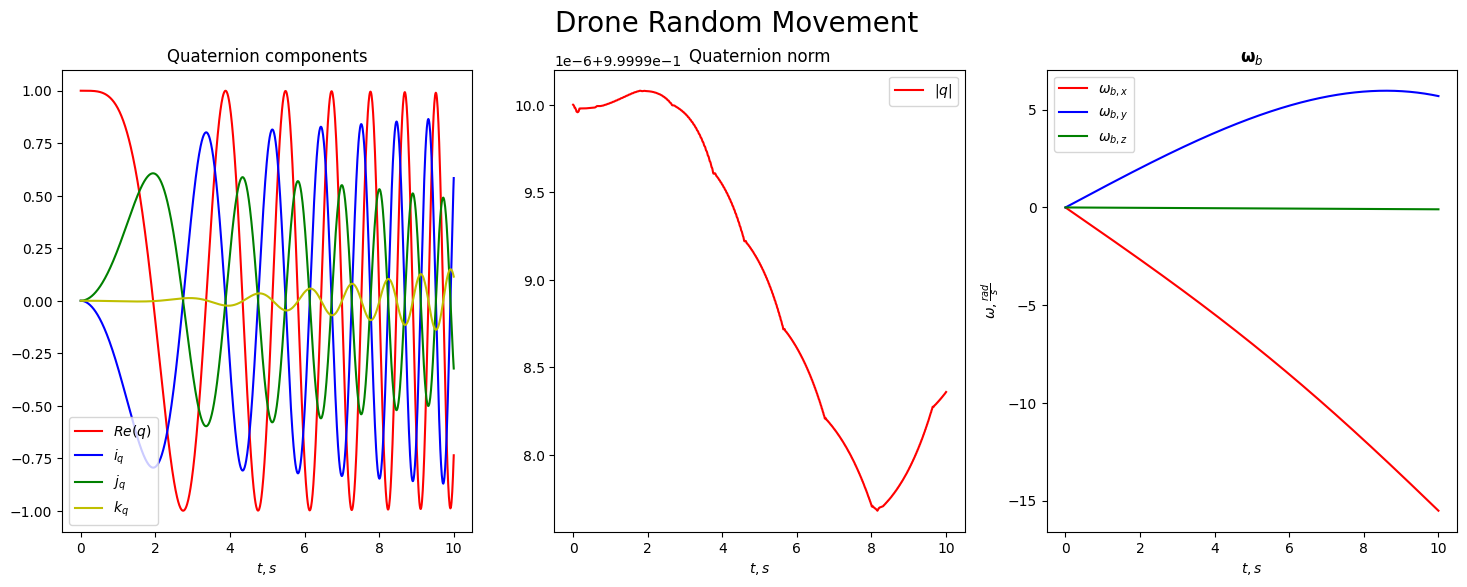

<Figure size 640x480 with 0 Axes>

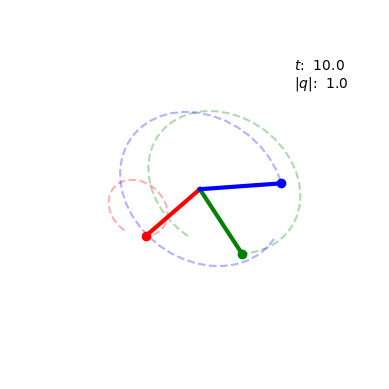

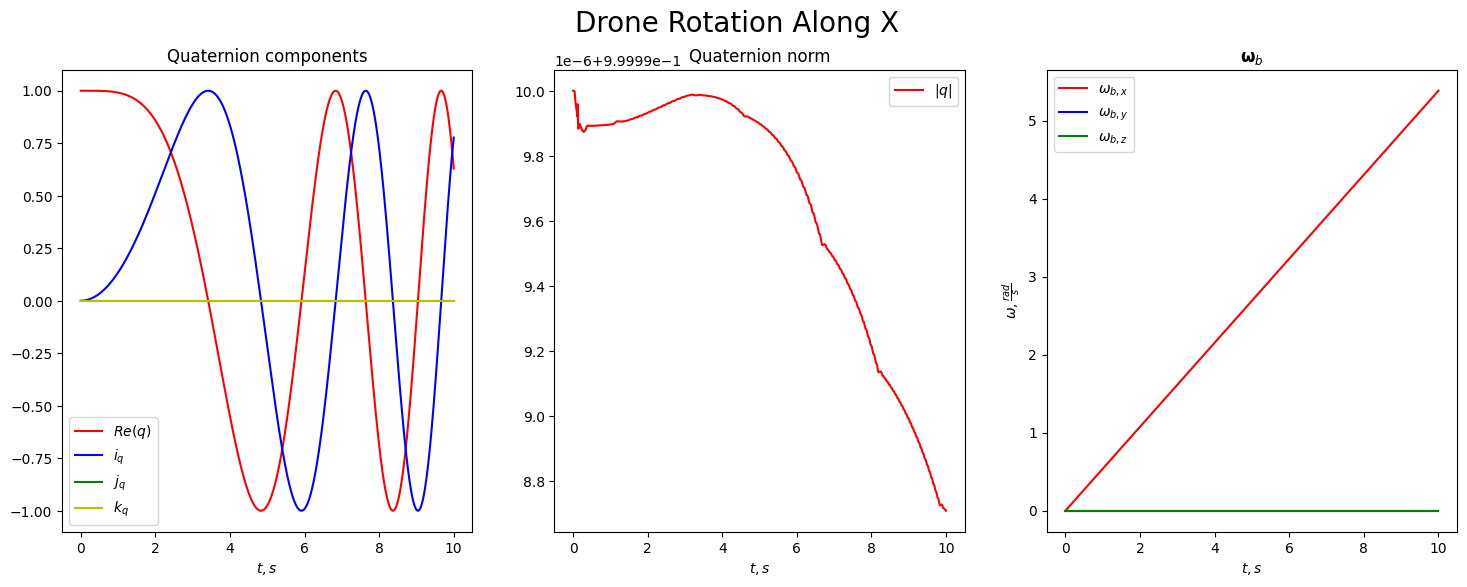

<Figure size 640x480 with 0 Axes>

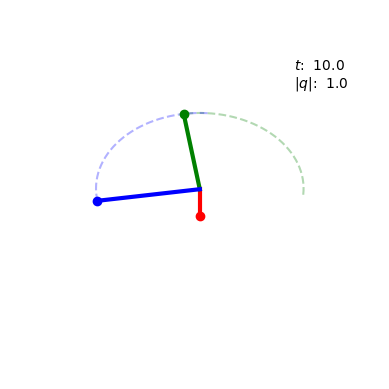

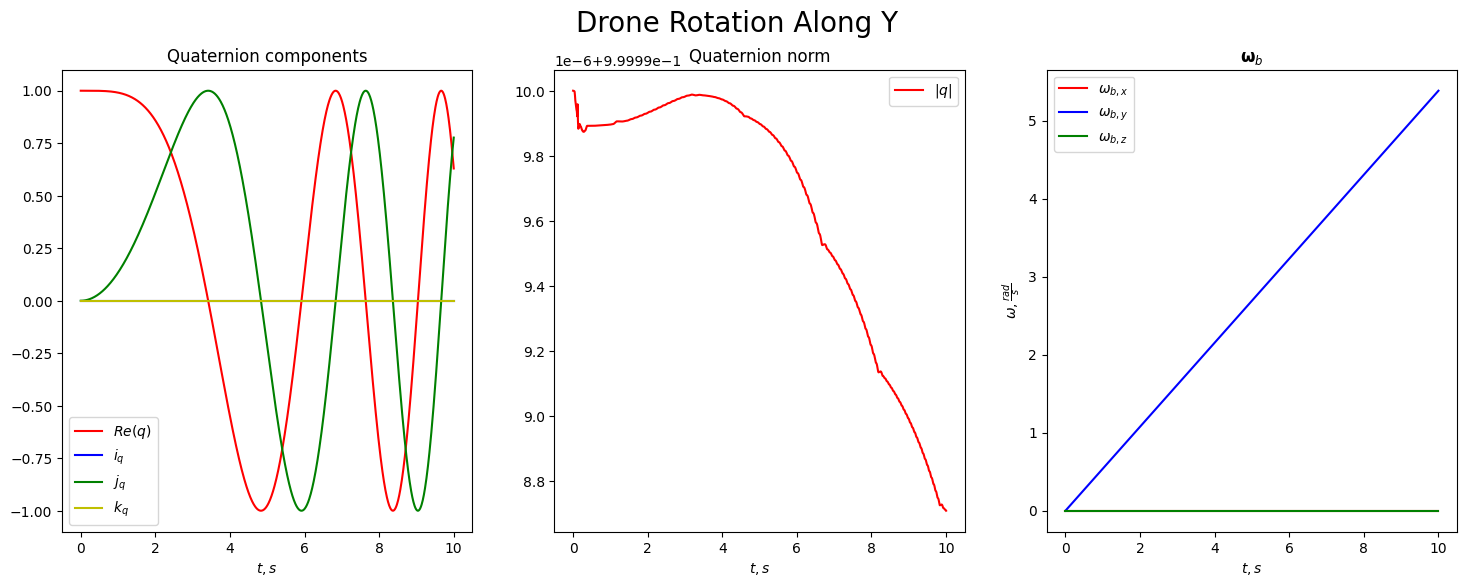

<Figure size 640x480 with 0 Axes>

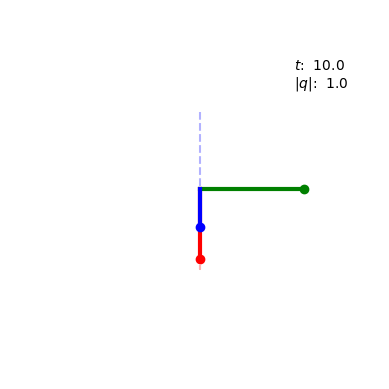

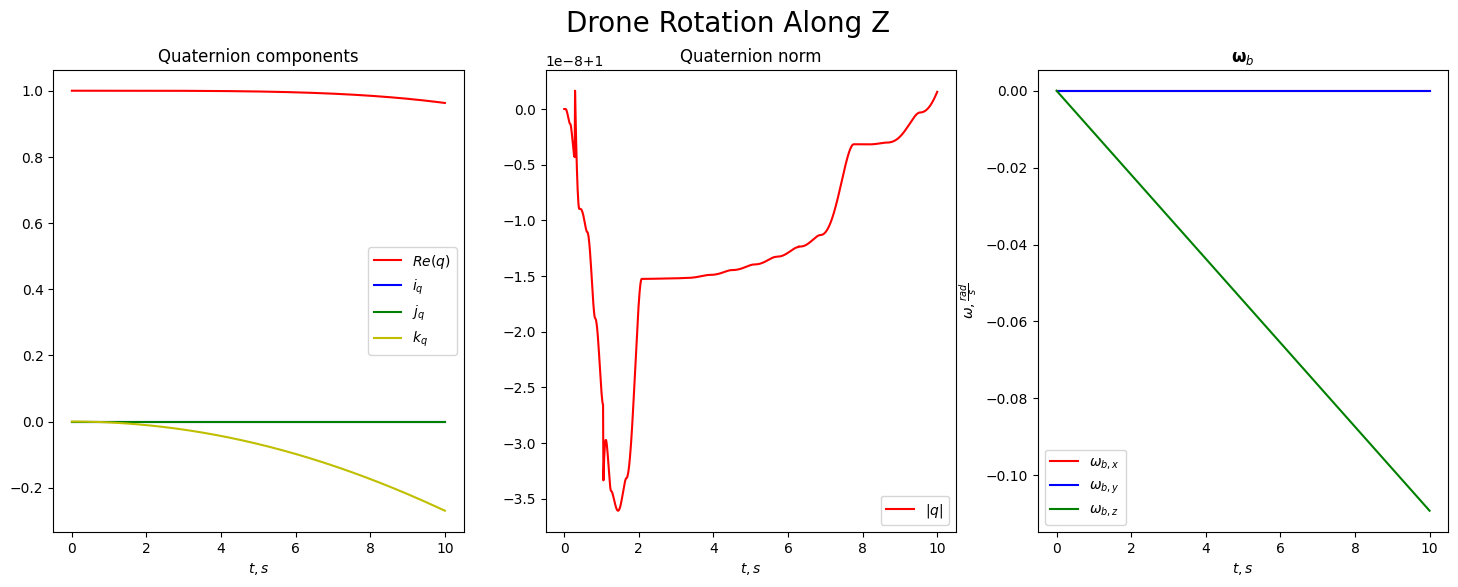

<Figure size 640x480 with 0 Axes>

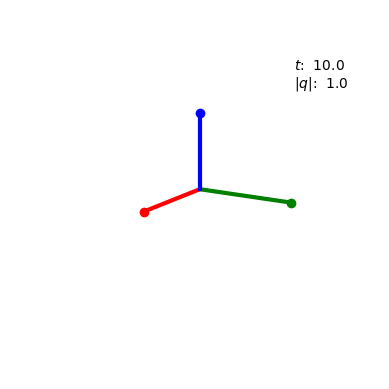

In [53]:
def plot_results_2(q_s: np.ndarray, omegas: np.ndarray, t_span: np.ndarray, title: str):
    fig: plt.Figure
    axes: List[plt.Axes]
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.suptitle(title, fontsize=20)

    axes[0].set_title('Quaternion components')
    axes[0].plot(t_span, q_s[:, 0], color='r', label='$Re(q)$')
    axes[0].plot(t_span, q_s[:, 1], color='b', label='$i_q$')
    axes[0].plot(t_span, q_s[:, 2], color='g', label='$j_q$')
    axes[0].plot(t_span, q_s[:, 3], color='y', label='$k_q$')
    axes[0].set_xlabel('$t, s$')
    axes[0].legend(loc='best')

    axes[1].set_title('Quaternion norm')
    axes[1].plot(t_span, np.linalg.norm(q_s, axis=1), color='r', label='$|q|$')
    axes[1].set_xlabel('$t, s$')
    axes[1].legend(loc='best')

    axes[2].set_title(r'$\mathbf{\omega}_b$')
    axes[2].plot(t_span, omegas[:, 0], color='r', label=r'$\omega_{b,x}$')
    axes[2].plot(t_span, omegas[:, 1], color='b', label=r'$\omega_{b,y}$')
    axes[2].plot(t_span, omegas[:, 2], color='g', label=r'$\omega_{b,z}$')
    axes[2].set_ylabel(r'$\omega, \frac{rad}{s}$')
    axes[2].set_xlabel('$t, s$')
    axes[2].legend(loc='best')

    plt.show()

    # Animate rotation
    plt.clf()
    rot_ms = []
    for q in q_s:
        rot_ms.append(qt_rot(q))
    stats = [['$t$', t_span], ['$|q|$', np.linalg.norm(q_s, axis=1)]]
    animation = visualize_rotation(np.array(rot_ms), stats=stats, verbose=False, show=False)

    title = title.replace(' ', '_')
    with open(f'task_2_{title}.html', 'w') as f:
        f.write(animation.to_jshtml())


def state_1(x: np.ndarray, _: float, vels: np.ndarray) -> np.ndarray:
    q = x[:4]
    omega = x[4:]
    return np.r_[
        q_mul(q / np.linalg.norm(q), complete(omega)) / 2,
        INERTIA_INV.dot(TAU_MATRIX.dot(vels) + np.cross(omega, INERTIA.dot(omega)))
    ]


def sim_drone(q_0: np.ndarray, omega_0: np.ndarray, vels: np.ndarray, title: str):
    x_0 = np.r_[q_0, omega_0]
    sol = odeint(state_1, x_0, T_SPAN, (vels,))
    plot_results_2(sol[:, :4], sol[:, 4:], T_SPAN, title)


sim_drone(Q_O, OMEGA_0, VELOCITIES, 'Drone Random Movement')
sim_drone(Q_O, OMEGA_0, np.array([1.1, -1.2, 1.1, -1]), 'Drone Rotation Along X')
sim_drone(Q_O, OMEGA_0, np.array([1, -1.1, 1.2, -1.1]), 'Drone Rotation Along Y')
sim_drone(Q_O, OMEGA_0, np.array([1.2, -1, 1.2, -1]), 'Drone Rotation Along Z')

#### **Problem №3: Springy Double Pendulum**

Consider the following system:


<p align="center">
<img src="https://drive.google.com/uc?id=191DRVGUMVNG9qGNzdw62jPk3N_JrcXgJ" alt="drawing" width="50%" style="margin:auto"/>
</p>


with parameters given by:

In [3]:
m1 = 0.5  # [kg] - mass in the first joint
m2 = 1.0  # [kg] - mass on the end of spring
l1 = 1.0  # [m] - the length of second link
l2 = 0.8  # [m] - the length of spring at the rest
k = 200  # [N/m] the stifness of the spring
g = 9.81  # [m/s^2] the gravitational acceleration

Do the following:

* **[15 points]** Derive the dynamics of the system using Euler-Lagrange equations, and write the dynamics in the form: $\mathbf{M}(\mathbf{q})\ddot{\mathbf{q}} + \mathbf{C}(\mathbf{q},\dot{\mathbf{q}})\dot{\mathbf{q}} + \mathbf{g}(\mathbf{q}) = \mathbf{Q}$.

* **[15 points]** Set the external forces to zero: $\mathbf{Q} = \boldsymbol{0}$, and simulate the motion using a 4th-order Runge-Kutta algorithm, such that the system was initially at rest with the cartesian position of the second mass $\mathbf{r} 2 = [1.8, 0]$. Animate the resulting motion, plot the trajectories and the full energy of the system ( recall [practice 4](https://docs.google.com/document/d/17JVy8mS9g2jEDtrdaJnYGX3pBBGFVm5pjCG2oQ3rrS0/edit) )

* **[10 points]** Set the external torque on the first joint as follows: $\mathbf{Q}_1(t) = 10(\sin(t) - \mathbf{q}_1) - 0.2\dot{\mathbf{q}}_1$ and repeat the previous step.

Derived matrices:
$$M(\mathbf{q}) = \left[\begin{matrix}l_{1}^{2} \left(m_{1} + m_{2}\right) & l_{1} m_{2} q_{3} \cos{\left(q_{1} - q_{2} \right)} & - l_{1} m_{2} \sin{\left(q_{1} - q_{2} \right)}\\l_{1} m_{2} q_{3} \cos{\left(q_{1} - q_{2} \right)} & m_{2} q_{3}^{2} & 0\\- l_{1} m_{2} \sin{\left(q_{1} - q_{2} \right)} & 0 & m_{2}\end{matrix}\right]$$

$$
C(\mathbf{q}, \mathbf{\dot{q}}) =
\left[\begin{matrix}0 & l_{1} m_{2} \left(\dot{q}_2 q_{3} \sin{\left(q_{1} - q_{2} \right)} + \dot{q}_3 \cos{\left(q_{1} - q_{2} \right)}\right) & \dot{q}_2 l_{1} m_{2} \cos{\left(q_{1} - q_{2} \right)}\\- \dot{q}_1 l_{1} m_{2} q_{3} \sin{\left(q_{1} - q_{2} \right)} & \dot{q}_3 m_{2} q_{3} & \dot{q}_2 m_{2} q_{3}\\- \dot{q}_1 l_{1} m_{2} \cos{\left(q_{1} - q_{2} \right)} & - \dot{q}_2 m_{2} q_{3} & 0\end{matrix}\right]
$$

$$
g(\mathbf{q}) =
\begin{bmatrix}
    g l_{1} (m_{1} + m_{2}) \cos{(q_{1})} \\
    g m_{2} q_{3} \cos{(q_{2})} \\
    g m_{2} \sin{(q_{2})} - k (l_{2} - q_{3})
\end{bmatrix}
$$

In [4]:
def mass_matrix(q: np.ndarray) -> np.ndarray:
    q1, q2, q3 = q
    return np.array(
        [
            [(m1 + m2) * l1 ** 2, m2 * l1 * q3 * np.cos(q1 - q2), -l1 * m2 * np.sin(q1 - q2)],
            [m2 * l1 * q3 * np.cos(q1 - q2), m2 * q3 ** 2, 0],
            [-m2 * l1 * np.sin(q1 - q2), 0, m2]
        ]
    )


def corr(q: np.ndarray, q_dot: np.ndarray) -> np.ndarray:
    q1, q2, q3 = q
    dq1, dq2, dq3 = q_dot
    return np.array(
        [
            [0, m2 * l1 * (dq2 * q3 * np.sin(q1 - q2) + dq3 * np.cos(q1 - q2)), dq2 * l1 * m2 * np.cos(q1 - q2)],
            [-dq1 * l1 * m2 * q3 * np.sin(q1 - q2), dq3 * m2 * q3, dq2 * m2 * q3],
            [-dq1 * l1 * m2 * np.cos(q1 - q2), -dq2 * m2 * q3, 0]
        ]
    )


def grav_grad(q: np.ndarray) -> np.ndarray:
    q1, q2, q3 = q
    return np.array(
        [
            g * l1 * (m1 + m2) * np.cos(q1),
            g * m2 * q3 * np.cos(q2),
            g * m2 * np.sin(q2) - k * (l2 - q3)
        ]
    )

In [7]:
N = 3000
T_SPAN = np.linspace(0, 30, N)
Q_O = np.array([0, 0, 0.8])
DOT_Q_0 = np.array([0, 0, 0])

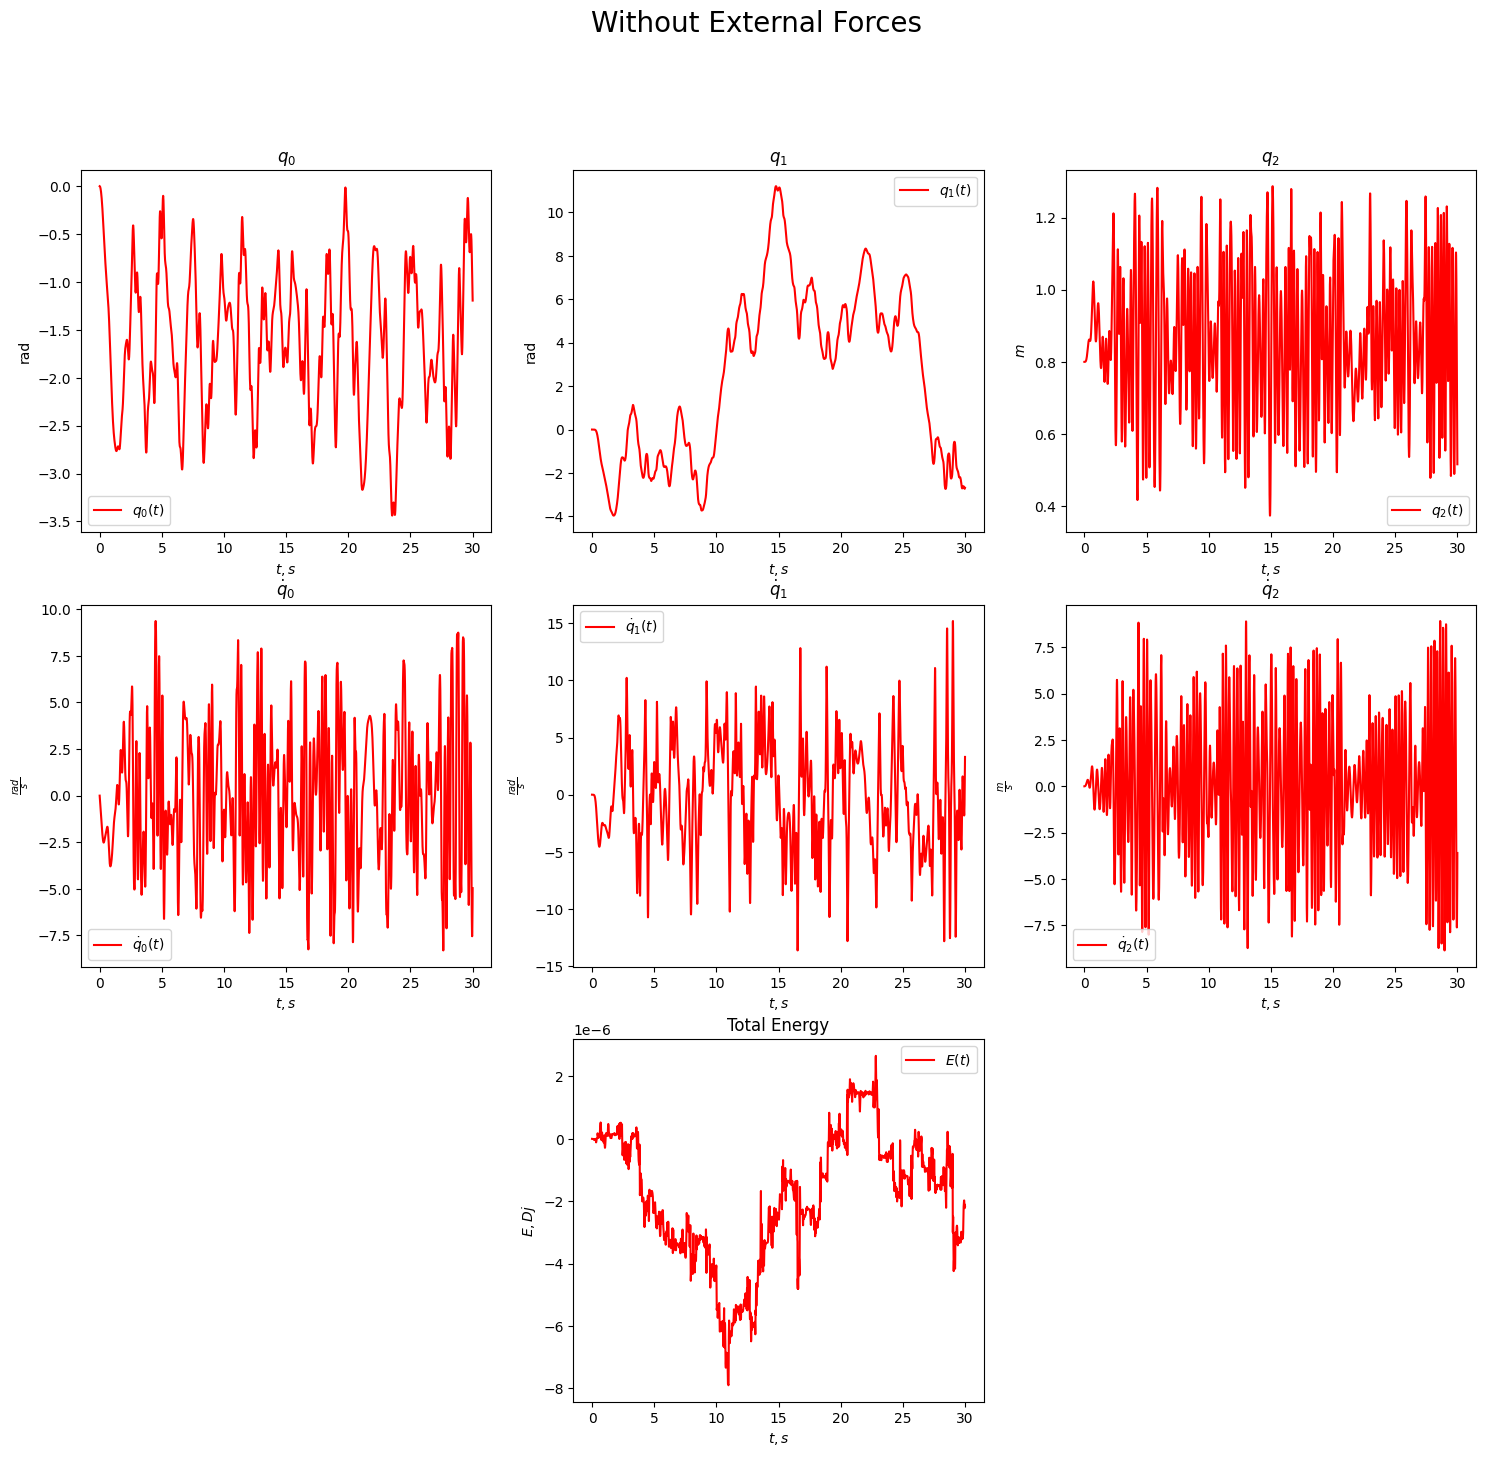

<Figure size 640x480 with 0 Axes>

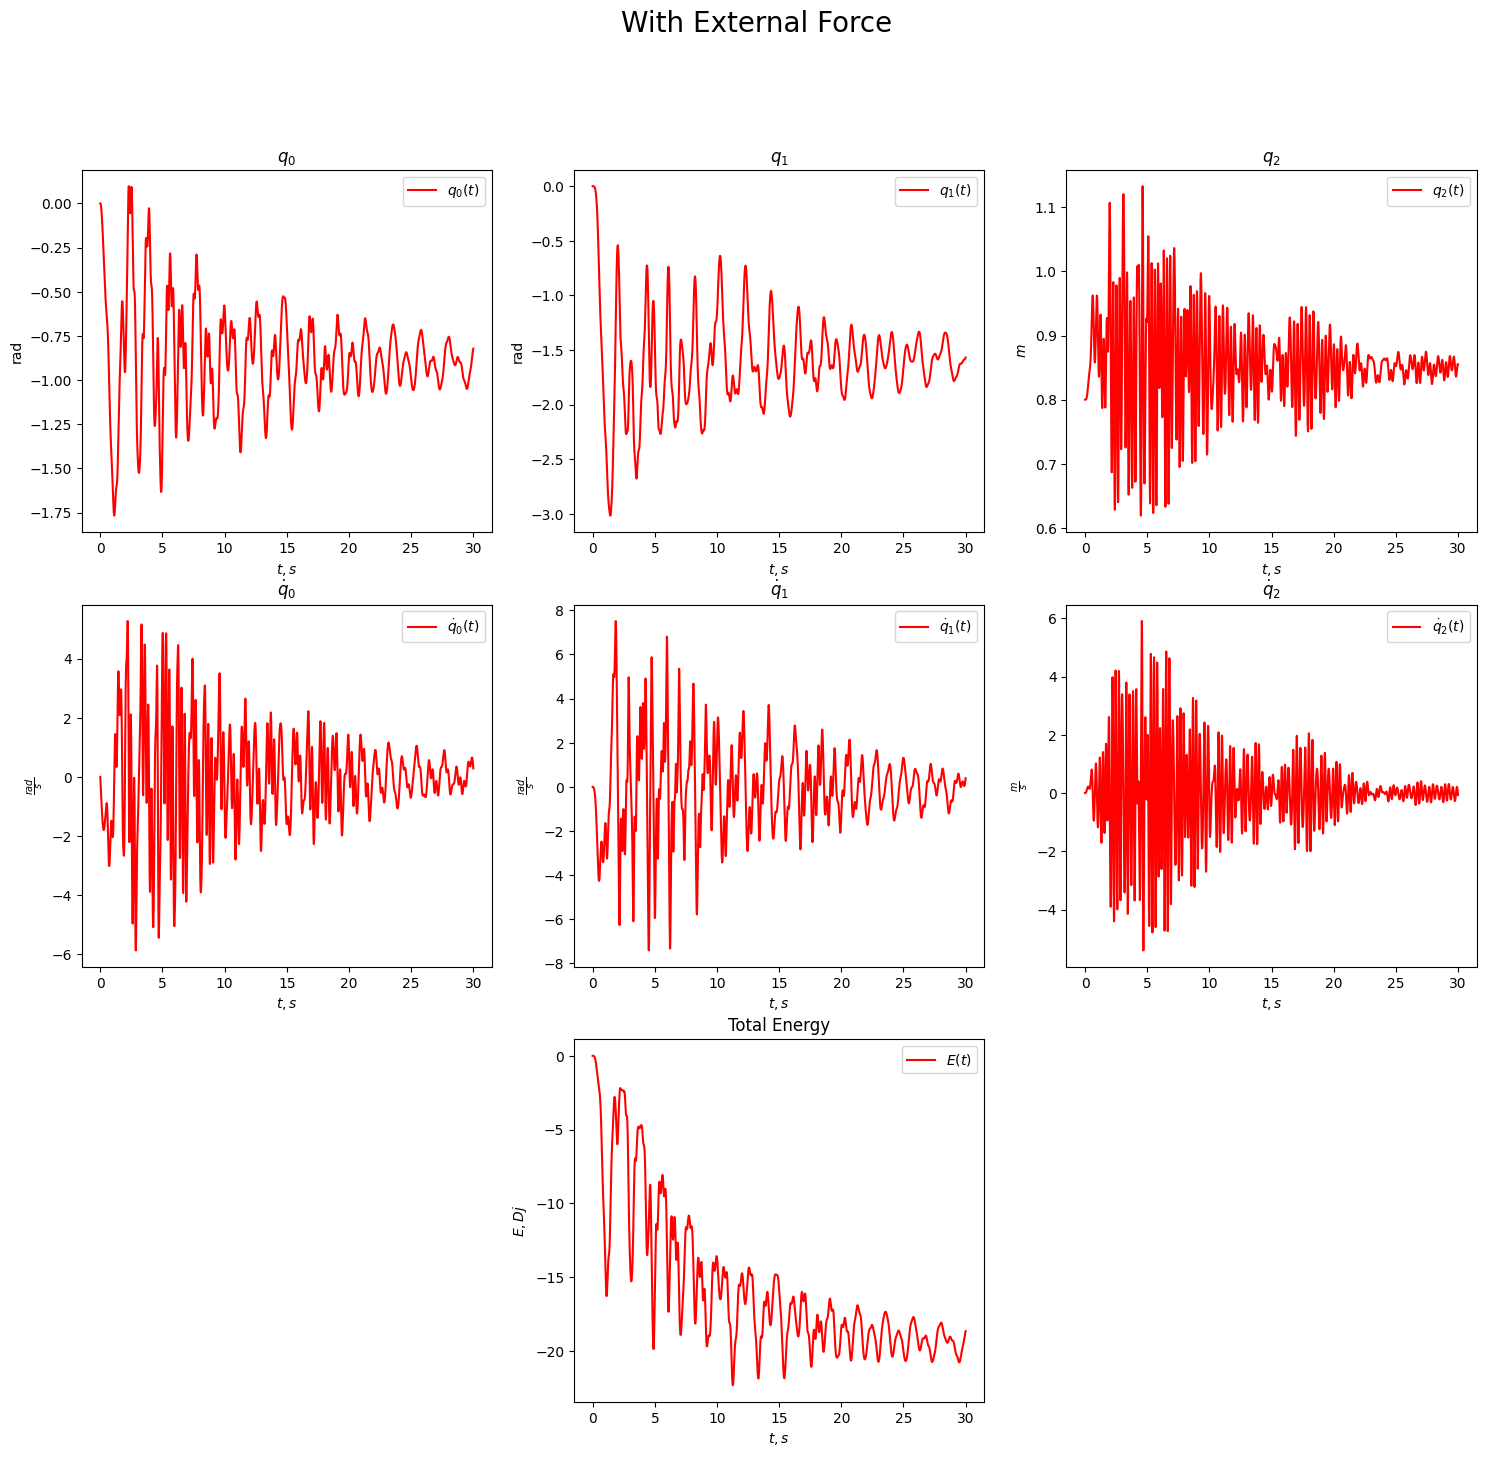

<Figure size 640x480 with 0 Axes>

In [8]:
def state_2(x: np.ndarray, _: float) -> np.ndarray:
    q = x[:3]
    dq = x[3:]
    inv_mass = np.linalg.inv(mass_matrix(q))
    cur_corr = corr(q, dq)
    cur_grad = grav_grad(q)
    return np.r_[
        dq, inv_mass.dot(-cur_corr.dot(dq) - cur_grad)
    ]


def state_3(x: np.ndarray, t: float) -> np.ndarray:
    q = x[:3]
    dq = x[3:]
    inv_mass = np.linalg.inv(mass_matrix(q))
    cur_corr = corr(q, dq)
    cur_grad = grav_grad(q)
    q_ext = np.array([10 * (0 * np.sin(t) - q[0]) - 0.2 * dq[0], 0, 0])
    return np.r_[
        dq, inv_mass.dot(q_ext - cur_corr.dot(dq) - cur_grad)
    ]


def energy(q: np.ndarray, dq: np.ndarray) -> np.ndarray:
    enr = []
    for cur_q, cur_dq in zip(q, dq):
        q_1, q_2, q_3 = cur_q
        enr.append(
            cur_dq.dot(mass_matrix(cur_q).dot(cur_dq)) / 2 +
            m1 * g * l1 * np.sin(q_1) +
            m2 * g * (l1 * np.sin(q_1) + q_3 * np.sin(q_2)) +
            (k * (q_3 - l2) ** 2) / 2
        )
    return np.array(enr)


def plot_results_3(q: np.ndarray, dq: np.ndarray, t_span: np.ndarray, title: str):
    fig: plt.Figure
    axes: List[List[plt.Axes]]
    fig, axes = plt.subplots(3, 3, figsize=(18, 16))
    plt.suptitle(title, fontsize=20)
    enr = energy(q, dq)

    for i in range(3):
        axes[0][i].set_title(f'$q_{i}$')
        axes[0][i].plot(t_span, q[:, i], color='r', label=f'$q_{i}(t)$')
        axes[0][i].set_xlabel('$t, s$')
        if i != 2:
            axes[0][i].set_ylabel('rad')
        else:
            axes[0][i].set_ylabel('$m$')
        axes[0][i].legend(loc='best')

    for i in range(3):
        axes[1][i].set_title(rf'$\dot{{q}}_{i}$')
        axes[1][i].plot(t_span, dq[:, i], color='r', label=rf'$\dot{{q}}_{i}(t)$')
        axes[1][i].set_xlabel('$t, s$')
        if i != 2:
            axes[1][i].set_ylabel(r'$\frac{rad}{s}$')
        else:
            axes[1][i].set_ylabel(r'$\frac{m}{s}$')
        axes[1][i].legend(loc='best')

    axes[2][0].remove()
    axes[2][2].remove()
    axes[2][1].set_title('Total Energy')
    axes[2][1].plot(t_span, enr, color='r', label='$E(t)$')
    axes[2][1].set_xlabel('$t, s$')
    axes[2][1].set_ylabel('$E, Dj$')
    axes[2][1].legend(loc='best')
    plt.show()

    # Animate rotation
    plt.clf()

    # calculate cartesian points of joints via forward kinematics
    points_1 = l1 * np.cos(q[:, 0]), l1 * np.sin(q[:, 0])
    points_2 = q[:, 2] * np.cos(q[:, 1]) + points_1[0], q[:, 2] * np.sin(q[:, 1]) + points_1[1]
    joint_points = [points_1, points_2]

    # Stats to print
    stats = [[r'time $t$', t_span],
             [r'$E$ ', enr]]
    # animate motion of double pendulum
    # anim = visualize_double_pendulum(
    #     joint_points,
    #     stats=stats,
    #     axes=False,
    #     show=False,
    #     verbose=False,
    #     trace_len=0.2,
    #     dt=t_span[1] - t_span[0]
    # )
    # title = title.replace(' ', '_')
    # with open(f'task_3_{title}.html', 'w') as f:
    #     f.write(anim.to_jshtml())


def sim_pendulum(q_0: np.ndarray, dot_q_0: np.ndarray,
                 t_span: np.ndarray,
                 state_f: Callable[[np.ndarray, float], np.ndarray],
                 title: str):
    x_0 = np.r_[q_0, dot_q_0]
    sol = odeint(state_f, x_0, t_span)
    plot_results_3(sol[:, :3], sol[:, 3:], t_span, title)


sim_pendulum(Q_O, DOT_Q_0, T_SPAN, state_2, 'Without External Forces')
sim_pendulum(Q_O, DOT_Q_0, T_SPAN, state_3, 'With External Force')

## Derivation

In [58]:
import sympy as sp

_t = sp.Symbol('t')
_g = sp.Symbol('g')
_ms = sp.symbols('m_1,m_2')
_ls = sp.symbols('l_1,l_2')
_qs = sp.Function('q_1')(_t), sp.Function('q_2')(_t), sp.Function('q_3')(_t)
_dqs = _qs[0].diff(_t), _qs[1].diff(_t), _qs[2].diff(_t)
_ddqs = _dqs[0].diff(_t), _dqs[1].diff(_t), _dqs[2].diff(_t)
_stf = sp.Symbol('k')

In [59]:
def s_rot_z(angle: sp.Symbol) -> sp.Matrix:
    res = sp.eye(3)
    res[0, 0] = sp.cos(angle)
    res[1, 1] = sp.cos(angle)
    res[0, 1] = -sp.sin(angle)
    res[1, 0] = sp.sin(angle)
    return res

In [60]:
cm_1: sp.Matrix = _ls[0] * sp.Matrix([sp.cos(_qs[0]), sp.sin(_qs[0])])
cm_2: sp.Matrix = _ls[0] * sp.Matrix([sp.cos(_qs[0]), sp.sin(_qs[0])]) + _qs[2] * sp.Matrix(
    [sp.cos(_qs[1]), sp.sin(_qs[1])])

j_cm_1: sp.Matrix = cm_1.jacobian(_qs)
j_cm_2: sp.Matrix = cm_2.jacobian(_qs)
j_cm_1.simplify()
j_cm_2.simplify()

In [61]:
_mass_matrix: sp.Matrix = sp.zeros(3, 3)
_mass_matrix += j_cm_1.T * _ms[0] * j_cm_1
_mass_matrix += j_cm_2.T * _ms[1] * j_cm_2
_mass_matrix.simplify()

In [62]:
def christoffel(mass: sp.Matrix, i: int, j: int, kk: int) -> sp.Symbol:
    return sp.simplify((mass[kk, j].diff(_qs[i]) + mass[kk, i].diff(_qs[j]) - mass[i, j].diff(_qs[kk])) / 2)


def coriolis(mass: sp.Matrix) -> sp.Matrix:
    res = sp.zeros(3, 3)
    for kk in range(3):
        for j in range(3):
            for i in range(3):
                res[kk, j] += christoffel(mass, i, j, kk) * _qs[i].diff(_t)
    return sp.simplify(res)


_corr = coriolis(_mass_matrix)

In [63]:
_check = sp.simplify(_mass_matrix.diff(_t) - 2 * _corr)
_check = sp.simplify(_check + _check.T)
_check

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

In [64]:
_potential = sp.Matrix(
    [
        _ms[0] * _g * _ls[0] * sp.sin(_qs[0]) +
        _ms[1] * _g * (_ls[0] * sp.sin(_qs[0]) + _qs[2] * sp.sin(_qs[1])) +
        (_stf * (_qs[2] - _ls[1]) ** 2) / 2
    ]
)
_potential.simplify()
_grav_grad: sp.Matrix = _potential.jacobian(_qs).T
_grav_grad.simplify()